In [1]:
import sys
import _init_paths
sys.path.append('../detection_models/')
import tensorflow as tf

#import matplotlib
#matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
%matplotlib inline

from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import numpy as np
import os, sys, cv2
import argparse
from networks.factory import get_network

# CLASSES =('__background__', 'arm')

# CLASSES =('__background__', 
#                             "box",
#                             "gum",
#                             "marker",
#                             "pen",
#                             "postit",
#                             "scissors",
#                             "tape",
#                             "usb"
#                              )


In [2]:
import model_conf

In [3]:
sess = tf.InteractiveSession()

In [4]:
models = model_conf.setup(sess)

[<tf.Tensor 'office_supplies/conv5_3/office_supplies/conv5_3:0' shape=(?, ?, ?, 512) dtype=float32>, <tf.Tensor 'office_supplies/rois:0' shape=(?, 5) dtype=float32>]
[<tf.Tensor 'arm/conv5_3/arm/conv5_3:0' shape=(?, ?, ?, 512) dtype=float32>, <tf.Tensor 'arm/rois:0' shape=(?, 5) dtype=float32>]


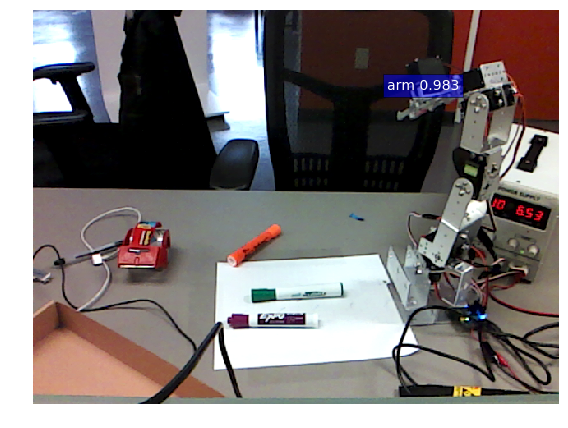

In [37]:
im = col
# imloc = "../data/images/office_supplies/images/66.jpg"
# im = cv2.imread(imloc)
dd = models[1].detect(im)['arm']

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im)
class_name = 'arm'
bbox = dd[0,:4]
score = dd[0,4]
ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')
plt.axis('off')
plt.tight_layout()
plt.draw()


In [ ]:
import model_containers

In [38]:
bbox

array([ 430.44766235,   98.37102509,  498.90908813,  140.0166626 ], dtype=float32)

In [ ]:

#CLASSES = ('__background__','person','bike','motorbike','car','bus')

def vis_detections(im, class_name, dets,ax, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

           ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


In [ ]:

def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join(cfg.DATA_DIR, 'office_supplies', 'images', image_name)
    #im_file = os.path.join('/home/corgi/Lab/label/pos_frame/ACCV/training/000001/',image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')

    CONF_THRESH = 0.15
    NMS_THRESH = 0.08
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, ax, thresh=CONF_THRESH)


In [ ]:
cfg.TEST.HAS_RPN = True  # Use RPN for proposals
gpu_id = 1
demo_net = 'VGGnet_test'
model = '/code/images/FastRcnnDetect/output/faster_rcnn_end2end/armpos/VGGnet_fast_rcnn_iter_2000.ckpt'
# demo_net = "Robonet_test"
# model = "/data/code/Faster-RCNN_TF/output/faster_rcnn_end2end/office_supplies/VGGnet_fast_rcnn_iter_200.ckpt"
# model = "/data/code/Faster-RCNN_TF/output/faster_rcnn_end2end/armpos/VGGnet_fast_rcnn_iter_2000.ckpt"

In [ ]:
cfg.DATA_DIR

In [ ]:
# image_name = 'pedestrian_cars.jpg'
# im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
im = cv2.imread("/data/code/Faster-RCNN_TF/data/armpos/images/10.jpg")
im.shape

In [ ]:
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))


In [ ]:
net = get_network(demo_net)

In [ ]:
saver = tf.train.Saver()

In [ ]:
saver.restore(sess, model)

print('\n\nLoaded network {:s}'.format(model))

In [ ]:
from networks import VGGnet_test

def load_vgg_net(sess, scope_name, model_ckpt_loc, n_classes):
    with tf.variable_scope(scope_name):
        net = VGGnet_test(n_classes=n_classes)
        vars_in_net = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope_name)
        saver = tf.train.Saver(var_list=dict([(var.name.replace('%s/'%(scope_name) ,'').replace(':0',''), var) 
                                              for var in vars_in_net]))
        saver.restore(sess, model_ckpt_loc)

In [ ]:
arm_model = '/code/images/FastRcnnDetect/output/faster_rcnn_end2end/armpos/VGGnet_fast_rcnn_iter_2000.ckpt'
obj_model = '/code/images/FastRcnnDetect/output/faster_rcnn_end2end/office_supplies/VGGnet_fast_rcnn_iter_200.ckpt'
obj_net = load_vgg_net(sess, 'obj', obj_model, 9)
arm_net = load_vgg_net(sess, 'arm', arm_model, 2)

In [ ]:
splits = ['obj', 'arm']
excepts = {'conv1_1','conv1_2', 'conv2_1', 'conv1_1'}
def split_model(model_dict, splits, excepts):
    split_dict = {}
    split_maps = [(key, [split + '_' + key for split in splits]) 
     if key not in excepts 
     else (key, [key])  for key in model_dict.keys()]
    for (inky, outkys) in split_maps:
        for outky in outkys:
            split_dict[outky] = model_dict[inky]
    return split_dict
    

In [ ]:
split_dict = split_model(out_dict, splits, excepts)

In [ ]:
split_dict.keys()

In [ ]:
with open('/data/tmp/split_trained_model.npy', 'w') as f:
    np.save(f, split_dict)

In [ ]:
split_dict['arm_fc7']

In [ ]:

im_names = ['11.jpg', '33.jpg', '44.jpg', '55.jpg', '66.jpg']
#im_names = ['000456.jpg']
for im_name in im_names:
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Demo for data/demo/{}'.format(im_name))
    demo(sess, net, im_name)

plt.show()

In [ ]:
filename = '/data/robotics/raw_position_images/train_2' + '.tfrecords'

example = tf.train.Example()
pi = tf.python_io.tf_record_iterator(filename)
example.ParseFromString(pi.next())

dat = np.fromstring(example.features.feature["left_image"].bytes_list.value[0], dtype=np.uint8)


im = dat.reshape((480, 640, 3))


In [ ]:
list(enumerate([1,2][1:]))

In [ ]:
scores, boxes = im_detect(sess, net, im)

In [ ]:
scores.shape

In [ ]:
# im = im[:, :, (2, 1, 0)]
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(im, aspect='equal')

CONF_THRESH = 0.04
NMS_THRESH = 0.03
for cls_ind, cls in enumerate(CLASSES[1:]):
    cls_ind += 1 # because we skipped background
    print cls_ind
    print scores.shape
    cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes,
                      cls_scores[:, np.newaxis])).astype(np.float32)
    keep = nms(dets, NMS_THRESH)
    dets = dets[keep, :]
    print(keep)
    vis_detections(im, cls, dets, ax, thresh=CONF_THRESH)


In [ ]:
dets = np.hstack((cls_boxes,
                  cls_scores[:, np.newaxis])).astype(np.float32)
keep = nms(dets, NMS_THRESH)


In [ ]:
np.where(dets[:, -1] >= 0.04)[0]

In [ ]:
dets[keep, -1]

In [ ]:
cls_ind = 2
boxes[:, 4*cls_ind:4*(cls_ind + 1)]

In [ ]:

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(im)
fig.canvas.mpl_connect( "button_press_event", )

In [ ]:
scores, boxes = im_detect(sess, net, im)

In [ ]:
len(scores), len(boxes)

In [ ]:
np.hstack([scores, boxes]).

In [ ]:
import json
json.dumps(d)

### Loading multiple models

In [ ]:
model_location = '/home/karthik/code/images/FastRcnnDetect/output/faster_rcnn_end2end/npy/split_trained_model.npy'

In [ ]:
net.load(model_location, sess)

In [ ]:
dat = np.load(model_location)

In [ ]:
sess.run(tf.global_variables_initializer())

In [ ]:
layers = net.layers
for (name, layer) in layers.items():
    print name
    allvsrs = tf.get_collection(tf.GraphKeys.VARIABLES, layer)
    print len(allvsrs)
    for variable in allvsrs:
        print name, variable.name


In [ ]:
layers

In [ ]:
len(net.layers)

In [ ]:
dat.item().keys()

## locating the 3d position of the arm

In [31]:
from operator import mul
col_sz = (480, 640, 3)
pnt_sz = (480, 640, 3)
cad_sz = (480, 640, 3)

col_dtype = np.uint8
dep_dtype = np.uint16
cad_dtype = np.uint8
pnt_dtype = np.float32

col_start = 0
col_end = reduce(mul, col_sz)
pnt_start = col_end
pnt_end = pnt_start + reduce(mul, pnt_sz)*4
cad_start = pnt_end

def from_buffer(im_str, sz, dtype_dat):
    f1 = np.fromstring(im_str, dtype=dtype_dat)
    return f1.reshape(sz)    

def get_images(iminfo):
    col = from_buffer(iminfo [:col_end], col_sz, col_dtype)
    pnt = from_buffer(iminfo[pnt_start: pnt_end], pnt_sz, pnt_dtype)
    cad = from_buffer(iminfo[cad_start:], cad_sz, cad_dtype)
    return col, pnt, cad


In [173]:
reciter = tf.python_io.tf_record_iterator('/data/robotics/intel_camera_data/train_2_.tfrecords')

In [174]:
example = tf.train.Example()


In [175]:
results = []

In [176]:
for res in reciter:
    example.ParseFromString(res)
    iminfo = example.features.feature['iminfo']

    col, pnt, cad = get_images(iminfo.bytes_list.value[0])

    arm = col[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2]), :]

    mask = cadarm > 0
    mask = mask.astype(np.uint8)
    masked_arm = arm*mask


    result = []
    for i in range(-5,5):
        for j in range(-5,5):
            y_offset_new = y_offset + i
            x_offset_new = x_offset + j
            cadarm = cad[y_offset_new + int(bbox[1]):y_offset_new + int(bbox[3]),
                         x_offset_new+int(bbox[0]):x_offset_new+int(bbox[2]), :]
            mask = cadarm > 0
            mask = mask.astype(np.uint8)
            masked_arm = arm*mask
            result.append((i, j, norm(masked_arm - cadarm)))

    y_err, x_err, scr =  sorted(result, key=lambda x: x[-1])[0]

    x_offset = 40+x_err
    y_offset = 10+y_err
    y_strt = y_offset + int(bbox[1])
    y_end = y_offset + int(bbox[3])
    x_strt = x_offset+int(bbox[0])
    x_end = x_offset+int(bbox[2])
    cadarm = cad[y_strt:y_end, x_strt:x_end, :]
    pntarm = pnt[y_strt:y_end, x_strt:x_end, :]

    wid,hei,col = pntarm.shape
    pntarm_flat = pntarm.reshape((wid*hei, col))

    nonzero = pntarm_flat[np.where((norm(pntarm_flat, axis=1)>0) & (pntarm_flat[:,2]<1)),]

    (x,y,z) = nonzero[0,...].mean(axis=0)
    motor_pos = np.asarray( example.features.feature['motor_pos'].float_list.value )
    results.append((motor_pos, np.asarray((x,y,z))))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


DataLossError: truncated record at 801808965

In [177]:
len(results)

145

In [172]:
motor_pos

array([-0.66242629, -0.07064177, -0.14000471, -0.2925269 ,  0.        ])